In [202]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import time
from bayes_opt import BayesianOptimization 

In [125]:
import tensorflow

In [126]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [127]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')
dataset_hc_c_d = pd.read_csv('dataset/HomeCredit_columns_description.csv',encoding="ISO-8859-1")
dataset_pos_cash_b = pd.read_csv('dataset/POS_CASH_balance.csv')
dataset_ins_pay = pd.read_csv('dataset/installments_payments.csv')
dataset_c_c_bal = pd.read_csv('dataset/credit_card_balance.csv')
dataset_br = pd.read_csv('dataset/bureau.csv')
dataset_prev_app = pd.read_csv('dataset/previous_application.csv')
dataset_br_bal = pd.read_csv('dataset/bureau_balance.csv')

In [128]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [129]:
dataset_train['FLAG_DOCUMENT_18'].isnull().sum()

0

In [130]:
dataset_train['FLAG_DOCUMENT_19'].isnull().sum()

0

In [131]:
dataset_train['FLAG_DOCUMENT_20'].isnull().sum()

0

In [133]:
dataset_train.shape

(307511, 122)

In [134]:
dataset_train = dataset_train.dropna(axis='columns')

In [135]:
dataset_train.shape

(307511, 55)

In [137]:
dataset_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,1,1,MONDAY,11,0,0,0,0,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,1,1,1,1,1,0,2,2,WEDNESDAY,16,0,0,0,0,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,1,1,0,1,1,0,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449,-4597.0,-2379,1,1,1,1,0,0,3,3,MONDAY,16,0,0,0,0,1,1,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099,365243,-7427.0,-3514,1,0,0,1,0,0,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.019689,-14469,-2019,-14437.0,-3992,1,1,0,1,0,0,2,2,THURSDAY,8,0,0,0,0,0,0,Electricity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    30000
1    20000
Name: SK_ID_CURR, dtype: int64

In [140]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(30000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [141]:
dataset_train.shape

(50000, 55)

In [142]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    30000
1    20000
Name: SK_ID_CURR, dtype: int64

In [143]:
dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)

In [144]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,232445,1,Cash loans,M,Y,Y,2,292500.0,755190.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.024610,-16948,-5883,-3553.0,-503,1,1,1,1,1,0,2,2,TUESDAY,10,0,0,0,0,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,191010,0,Cash loans,F,N,N,0,157500.0,1125000.0,Commercial associate,Secondary / secondary special,Widow,House / apartment,0.072508,-19898,-1103,-62.0,-2756,1,1,1,1,0,0,1,1,TUESDAY,18,0,0,0,0,0,0,Trade: type 1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,333902,0,Cash loans,F,N,N,0,90000.0,450000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.025164,-23291,365243,-13126.0,-4389,1,0,0,1,1,0,2,2,TUESDAY,15,0,0,0,0,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,419860,0,Cash loans,F,N,Y,0,180000.0,288873.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.072508,-23232,365243,-1508.0,-3069,1,0,0,1,1,0,1,1,MONDAY,9,0,0,0,0,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,157224,0,Cash loans,F,N,Y,0,108000.0,207306.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.035792,-23321,365243,-7775.0,-4495,1,0,0,1,0,0,2,2,THURSDAY,11,0,0,0,0,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
dataset_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [147]:
dataset_hc_c_d.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [148]:
dataset_pos_cash_b.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [149]:
dataset_ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [150]:
dataset_c_c_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [151]:
dataset_br.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [152]:
dataset_prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
dataset_br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [154]:
dataset_train = dataset_train.dropna(axis='rows')

In [155]:
dataset_train["TARGET"].value_counts(dropna=False)

0    30000
1    20000
Name: TARGET, dtype: int64

In [156]:
dataset_train["ORGANIZATION_TYPE"].value_counts(dropna=False)

Business Entity Type 3    11747
XNA                        7865
Self-employed              6879
Other                      2624
Business Entity Type 2     1753
Medicine                   1659
Government                 1633
Trade: type 7              1331
School                     1312
Construction               1269
Kindergarten               1078
Business Entity Type 1      998
Transport: type 4           901
Industry: type 3            596
Trade: type 3               594
Security                    582
Industry: type 9            534
Housing                     516
Industry: type 11           433
Agriculture                 405
Bank                        374
Postal                      368
Restaurant                  353
Military                    351
Police                      322
Transport: type 2           321
Trade: type 2               299
Services                    269
Security Ministries         266
Transport: type 3           255
Industry: type 1            191
Industry

In [157]:
corr = dataset_train.corr(method='pearson')

In [158]:
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,1.000000,-0.001590,-0.005246,-0.006318,0.006479,0.000119,-0.004769,0.001381,-0.002555,0.000119,NaN,-0.001371,0.006812,0.005544,0.012726,0.003125,-0.004526,-0.003576,0.010126,0.000993,0.001610,-0.000736,0.002619,-0.004605,-0.004332,-0.003120,-0.008560,-0.004791,-0.002817,0.005429,-0.006747,0.004922,0.008927,0.005728,-0.002137,NaN,0.007593,-0.005941,0.014402,0.003268,0.004472,-0.000981,-0.006105,0.002423,-0.000435
TARGET,-0.001590,1.000000,0.031939,-0.002285,-0.055373,-0.062611,0.137368,-0.079706,0.076226,0.092933,NaN,0.081559,0.050494,0.002515,-0.041428,-0.010046,0.103781,0.107769,-0.043887,0.011318,0.011231,0.004742,0.074808,0.086039,0.055583,0.008165,0.078456,-0.003652,-0.002375,-0.048248,-0.003873,-0.014193,-0.010007,-0.003652,-0.006396,NaN,-0.025271,-0.018159,-0.012128,-0.022850,-0.006607,-0.015452,-0.007748,-0.000381,0.008167
CNT_CHILDREN,-0.005246,0.031939,1.000000,0.007372,-0.002432,-0.034282,0.303327,-0.220111,0.174101,-0.031794,NaN,0.220919,0.055964,-0.005679,-0.027192,0.018948,0.036148,0.035508,-0.014575,-0.014901,0.004491,0.014111,0.009012,0.058075,0.063724,-0.003128,0.051426,-0.002607,-0.022223,-0.146220,0.007572,0.054742,0.002912,-0.002607,-0.000313,NaN,0.004992,-0.004533,-0.001500,0.004527,0.000458,0.004342,-0.005140,-0.003688,-0.000856
AMT_INCOME_TOTAL,-0.006318,-0.002285,0.007372,1.000000,0.064431,0.026921,0.010237,-0.026431,0.007422,-0.000351,NaN,0.026377,-0.009950,-0.001823,-0.002729,0.015143,-0.035243,-0.037365,0.017932,0.012586,0.025661,0.024441,-0.000759,-0.001641,-0.000036,-0.000218,-0.004379,-0.000843,-0.000057,-0.018964,0.000864,0.027147,0.016328,0.000475,0.000928,NaN,0.010566,0.006974,0.003438,0.000893,0.000610,0.000745,0.000736,-0.000832,0.000153
AMT_CREDIT,0.006479,-0.055373,-0.002432,0.064431,1.000000,0.092793,-0.089242,-0.040746,-0.004915,-0.023835,NaN,0.039313,-0.039324,0.025084,0.018275,0.012853,-0.088874,-0.098247,0.043466,0.025439,0.047489,0.045175,-0.031056,-0.034335,-0.014302,0.021204,0.083726,-0.005912,-0.004659,-0.029738,-0.012910,0.070797,0.019847,0.001074,0.033582,NaN,0.048899,0.055344,0.025303,0.052113,0.010636,0.028163,0.021416,0.024324,-0.015313
REGION_POPULATION_RELATIVE,0.000119,-0.062611,-0.034282,0.026921,0.092793,1.000000,-0.045044,0.002787,-0.061346,-0.012264,NaN,-0.002917,-0.013303,-0.013009,0.088176,0.035655,-0.506967,-0.506489,0.164531,-0.013963,0.044000,0.073058,-0.057843,-0.053526,-0.021934,-0.003128,-0.078380,-0.000168,0.017825,0.007383,-0.003343,0.076206,0.042051,0.017742,0.023025,NaN,0.035381,0.033057,0.003259,0.004609,0.005444,0.009486,-0.003279,-0.003235,-0.002139
DAYS_BIRTH,-0.004769,0.137368,0.303327,0.010237,-0.089242,-0.045044,1.000000,-0.600493,0.325817,0.278882,NaN,0.604478,0.170681,-0.012873,-0.042753,0.077744,0.030715,0.029184,0.073865,0.066709,0.090554,0.063792,0.181361,0.239548,0.148575,-0.004228,0.117644,-0.001150,0.010722,-0.400036,0.001306,0.098420,0.020368,0.004451,0.041498,NaN,0.021155,0.024868,0.010887,0.014040,-0.001098,0.041900,0.001443,0.001833,0.026902
DAYS_EMPLOYED,0.001381,-0.079706,-0.220111,-0.026431,-0.040746,0.002787,-0.600493,1.000000,-0.210148,-0.261413,NaN,-0.999812,-0.225184,0.006952,0.021641,-0.052035,0.017083,0.017473,-0.076932,-0.039771,-0.102051,-0.089981,-0

In [159]:
type(corr)

pandas.core.frame.DataFrame

In [160]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.951160095757893
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.856450797190276
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8071867943941134


In [161]:
#Columnd to remove die to high correlation
columns_to_remove

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

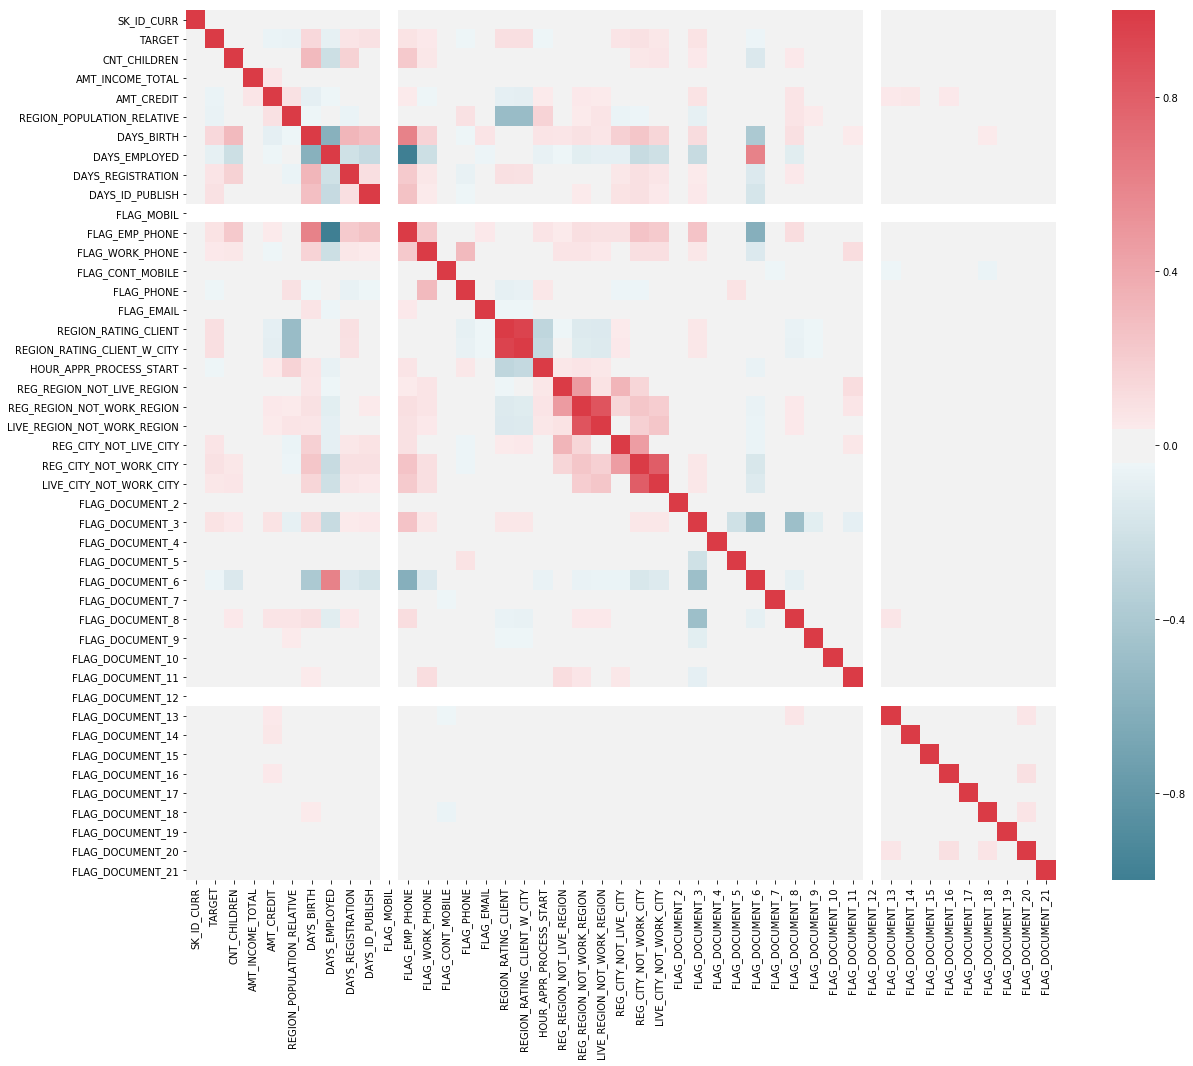

In [162]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [163]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [164]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,232445,1,Cash loans,M,Y,Y,2,292500.0,755190.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.024610,-16948,-5883,-3553.0,-503,1,1,1,1,1,0,TUESDAY,10,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,191010,0,Cash loans,F,N,N,0,157500.0,1125000.0,Commercial associate,Secondary / secondary special,Widow,House / apartment,0.072508,-19898,-1103,-62.0,-2756,1,1,1,1,0,0,TUESDAY,18,0,0,Trade: type 1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,333902,0,Cash loans,F,N,N,0,90000.0,450000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.025164,-23291,365243,-13126.0,-4389,1,0,0,1,1,0,TUESDAY,15,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,419860,0,Cash loans,F,N,Y,0,180000.0,288873.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.072508,-23232,365243,-1508.0,-3069,1,0,0,1,1,0,MONDAY,9,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,157224,0,Cash loans,F,N,Y,0,108000.0,207306.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.035792,-23321,365243,-7775.0,-4495,1,0,0,1,0,0,THURSDAY,11,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [165]:
pd.set_option('display.max_columns',None)

In [166]:
dataset_train.head(100)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,232445,1,Cash loans,M,Y,Y,2,292500.0,755190.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.024610,-16948,-5883,-3553.0,-503,1,1,1,1,1,0,TUESDAY,10,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,191010,0,Cash loans,F,N,N,0,157500.0,1125000.0,Commercial associate,Secondary / secondary special,Widow,House / apartment,0.072508,-19898,-1103,-62.0,-2756,1,1,1,1,0,0,TUESDAY,18,0,0,Trade: type 1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,333902,0,Cash loans,F,N,N,0,90000.0,450000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.025164,-23291,365243,-13126.0,-4389,1,0,0,1,1,0,TUESDAY,15,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,419860,0,Cash loans,F,N,Y,0,180000.0,288873.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.072508,-23232,365243,-1508.0,-3069,1,0,0,1,1,0,MONDAY,9,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,157224,0,Cash loans,F,N,Y,0,108000.0,207306.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.035792,-23321,365243,-7775.0,-4495,1,0,0,1,0,0,THURSDAY,11,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,363503,1,Cash loans,M,N,N,1,450000.0,450000.0,Working,Higher education,Civil marriage,With parents,0.003818,-10047,-218,-4319.0,-2549,1,1,1,1,0,0,WEDNESDAY,10,0,0,Realtor,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,367574,1,Cash loans,F,N,Y,1,135000.0,299250.0,Working,Secondary / secondary special,Married,House / apartment,0.022625,-19001,-11853,-11045.0,-2533,1,1,1,1,0,0,MONDAY,11,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,323091,1,Cash loans,M,Y,Y,0,180000.0,317979.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.031329,-8140,-227,-1149.0,-809,1,1,0,1,0,0,WEDNESDAY,13,0,0,Other,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,307631,1,Cash loans,F,N,Y,0,135000.0,601474.5,Commercial associate,Incomplete higher,Single / not married,With parents,0.006852,-8379,-541,-8379.0,-1051,1,1,0,1,0,0,TUESDAY,10,0,1,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,273958,1,Cash loans,M,N,N,1,135000.0,247275.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0.004960,-12754,-308,-3592.0,-3605,1,1,0,1,0,0,SATURDAY,14,0,1,Trade: type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [167]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [168]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column])
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

NAME_CONTRACT_TYPE - 50000 51
CODE_GENDER - 50000 53
FLAG_OWN_CAR - 50000 55
FLAG_OWN_REALTY - 50000 57
CNT_CHILDREN - 50000 69
NAME_INCOME_TYPE - 50000 77
NAME_EDUCATION_TYPE - 50000 82
NAME_FAMILY_STATUS - 50000 87
NAME_HOUSING_TYPE - 50000 93
ORGANIZATION_TYPE - 50000 151
Time Elapsed:- 
1.1849439144134521


In [170]:
columns_to_label_encode = columns_to_label_encode.append('WEEKDAY_APPR_PROCESS_START')
dataset_train = dataset_train.drop(columns_to_label_encode,axis=1)

In [171]:
dataset_train.shape

(50000, 140)

In [172]:
dataset_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE0,NAME_CONTRACT_TYPE1,CODE_GENDER0,CODE_GENDER1,FLAG_OWN_CAR0,FLAG_OWN_CAR1,FLAG_OWN_REALTY0,FLAG_OWN_REALTY1,CNT_CHILDREN0,CNT_CHILDREN1,CNT_CHILDREN2,CNT_CHILDREN3,CNT_CHILDREN4,CNT_CHILDREN5,CNT_CHILDREN6,CNT_CHILDREN7,CNT_CHILDREN8,CNT_CHILDREN9,CNT_CHILDREN10,CNT_CHILDREN11,NAME_INCOME_TYPE0,NAME_INCOME_TYPE1,NAME_INCOME_TYPE2,NAME_INCOME_TYPE3,NAME_INCOME_TYPE4,NAME_INCOME_TYPE5,NAME_INCOME_TYPE6,NAME_INCOME_TYPE7,NAME_EDUCATION_TYPE0,NAME_EDUCATION_TYPE1,NAME_EDUCATION_TYPE2,NAME_EDUCATION_TYPE3,NAME_EDUCATION_TYPE4,NAME_FAMILY_STATUS0,NAME_FAMILY_STATUS1,NAME_FAMILY_STATUS2,NAME_FAMILY_STATUS3,NAME_FAMILY_STATUS4,NAME_HOUSING_TYPE0,NAME_HOUSING_TYPE1,NAME_HOUSING_TYPE2,NAME_HOUSING_TYPE3,NAME_HOUSING_TYPE4,NAME_HOUSING_TYPE5,ORGANIZATION_TYPE0,ORGANIZATION_TYPE1,ORGANIZATION_TYPE2,ORGANIZATION_TYPE3,ORGANIZATION_TYPE4,ORGANIZATION_TYPE5,ORGANIZATION_TYPE6,ORGANIZATION_TYPE7,ORGANIZATION_TYPE8,ORGANIZATION_TYPE9,ORGANIZATION_TYPE10,ORGANIZATION_TYPE11,ORGANIZATION_TYPE12,ORGANIZATION_TYPE13,ORGANIZATION_TYPE14,ORGANIZATION_TYPE15,ORGANIZATION_TYPE16,ORGANIZATION_TYPE17,ORGANIZATION_TYPE18,ORGANIZATION_TYPE19,ORGANIZATION_TYPE20,ORGANIZATION_TYPE21,ORGANIZATION_TYPE22,ORGANIZATION_TYPE23,ORGANIZATION_TYPE24,ORGANIZATION_TYPE25,ORGANIZATION_TYPE26,ORGANIZATION_TYPE27,ORGANIZATION_TYPE28,ORGANIZATION_TYPE29,ORGANIZATION_TYPE30,ORGANIZATION_TYPE31,ORGANIZATION_TYPE32,ORGANIZATION_TYPE33,ORGANIZATION_TYPE34,ORGANIZATION_TYPE35,ORGANIZATION_TYPE36,ORGANIZATION_TYPE37,ORGANIZATION_TYPE38,ORGANIZATION_TYPE39,ORGANIZATION_TYPE40,ORGANIZATION_TYPE41,ORGANIZATION_TYPE42,ORGANIZATION_TYPE43,ORGANIZATION_TYPE44,ORGANIZATION_TYPE45,ORGANIZATION_TYPE46,ORGANIZATION_TYPE47,ORGANIZATION_TYPE48,ORGANIZATION_TYPE49,ORGANIZATION_TYPE50,ORGANIZATION_TYPE51,ORGANIZATION_TYPE52,ORGANIZATION_TYPE53,ORGANIZATION_TYPE54,ORGANIZATION_TYPE55,ORGANIZATION_TYPE56,ORGANIZATION_TYPE57
0,232445,1,292500.0,755190.0,0.024610,-16948,-5883,-3553.0,-503,1,1,1,1,1,0,10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,191010,0,157500.0,1125000.0,0.072508,-19898,-1103,-62.0,-2756,1,1,1,1,0,0,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,333902,0,90000.0,450000.0,0.025164,-23291,365243,-13126.0,-4389,1,0,0,1,1,0,15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [173]:
X = dataset_train.iloc[:,2:]
y = dataset_train['TARGET']

In [174]:
X.shape

(50000, 138)

In [175]:
y.shape

(50000,)

In [176]:
from sklearn.model_selection import train_test_split

In [177]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [178]:
y = np.array(y_train)

In [179]:
count = 0
for i in range(0,len(y)):
    if y[i] == 1:
       count = count + 1
print(count)

15981


In [180]:
X_train.shape

(40000, 138)

In [181]:
X_test.shape

(10000, 138)

In [182]:
from sklearn.linear_model import LogisticRegression

In [183]:
clf = LogisticRegression(C=0.4)
clf.fit(X_train,y_train)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [184]:
prediction = clf.predict(X_test)

In [185]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [186]:
accuracy_score(y_test,prediction)

0.5981

In [187]:
confusion_matrix(y_test,prediction)

array([[5981,    0],
       [4019,    0]])

In [188]:
dataset_train.shape

(50000, 140)

In [189]:
from sklearn.ensemble import RandomForestClassifier

In [190]:
classifier = RandomForestClassifier(verbose=2)
classifier.fit(X_train,y_train)

building tree 1 of 10
building tree 2 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [191]:
prediction = classifier.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [192]:
confusion_matrix(y_test,prediction).ravel()

array([4787, 1194, 2736, 1283])

In [193]:
accuracy_score(y_test,prediction)

0.607

In [194]:
from xgboost import XGBClassifier

In [195]:
boosting = XGBClassifier()
boosting.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [196]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.647

In [197]:
confusion_matrix(y_test,pred)

array([[5011,  970],
       [2560, 1459]])

In [198]:
from sklearn import svm

In [ ]:
clf = svm.SVC(gamma=0.001, C=1.0, kernel='poly')
clf.fit(X_train,y_train)

In [ ]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

In [ ]:
confusion_matrix(y_test,pred).ravel()